In [1]:
!git clone -b new-dataset https://github.com/lahirumanulanka/ann-visual-emotion

Cloning into 'ann-visual-emotion'...
remote: Enumerating objects: 184430, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 184430 (delta 51), reused 51 (delta 26), pack-reused 184334 (from 1)
Receiving objects: 100% (184430/184430), 2.70 GiB | 35.31 MiB/s, done.
Resolving deltas: 100% (11149/11149), done.
Updating files: 100% (36081/36081), done.


# CNN Transfer Learning for Visual Emotion Recognition

This notebook demonstrates how to implement transfer learning with CNN networks for visual emotion recognition. We'll use a pre-trained VGG16 model and fine-tune it for our emotion classification task.

## What is Transfer Learning?
Transfer learning is a machine learning technique where we use a model that has been trained on one task and adapt it for a related task. In our case, we'll use a CNN pre-trained on ImageNet and adapt it for emotion recognition.

## Benefits of Transfer Learning:
1. **Faster training**: We start with pre-trained weights instead of random initialization
2. **Better performance**: Especially when we have limited training data
3. **Lower computational requirements**: Less training time needed
4. **Proven feature extractors**: Pre-trained networks have learned robust low-level features

## Step 1: Import Required Libraries

In [2]:
import os
import sys
from pathlib import Path
import json
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Sklearn for metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda


In [3]:
# Data paths (modify these if running locally)

PROJECT_ROOT = Path('/content/ann-visual-emotion')
CSV_TRAIN = PROJECT_ROOT / 'data/processed/EmoSet_splits/train.csv'
CSV_VAL = PROJECT_ROOT / 'data/processed/EmoSet_splits/val.csv'
CSV_TEST = PROJECT_ROOT / 'data/processed/EmoSet_splits/test.csv'
LABEL_MAP_PATH = PROJECT_ROOT / 'data/processed/EmoSet_splits/label_map.json'
DATA_DIR = PROJECT_ROOT / 'data/raw/EmoSet'

# Check if files exist
print("Checking data files...")
for path in [CSV_TRAIN, CSV_VAL, CSV_TEST, LABEL_MAP_PATH]:
    if path.exists():
        print(f"✓ Found: {path}")
    else:
        print(f"✗ Missing: {path}")

# Load label map if it exists
if LABEL_MAP_PATH.exists():
    with open(LABEL_MAP_PATH, 'r') as f:
        label_map = json.load(f)
    num_classes = len(label_map)
    print(f'Number of emotion classes: {num_classes}')
    print(f'Emotion classes: {list(label_map.keys())}')
else:
    # Create a dummy label map for testing
    label_map = {'anger': 0,'fearful': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprised': 5}
    num_classes = len(label_map)
    print(f'Using dummy label map with {num_classes} classes: {list(label_map.keys())}')

Checking data files...
✓ Found: /content/ann-visual-emotion/data/processed/EmoSet_splits/train.csv
✓ Found: /content/ann-visual-emotion/data/processed/EmoSet_splits/val.csv
✓ Found: /content/ann-visual-emotion/data/processed/EmoSet_splits/test.csv
✓ Found: /content/ann-visual-emotion/data/processed/EmoSet_splits/label_map.json
Number of emotion classes: 7
Emotion classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## Step 3: Custom Dataset Class

We'll create a custom dataset class that handles both grayscale and RGB images for transfer learning.

In [4]:
class EmotionDataset(Dataset):
    """
    Custom dataset class for emotion recognition.
    Supports grayscale images; will expand to 3 channels if required by backbone.
    """

    def __init__(self, dataframe, root_dir, transform=None, label_map=None, rgb=False, expand_to_three=True):
        """
        Args:
            dataframe: pandas DataFrame with image paths and labels
            root_dir: Root directory containing images
            transform: Optional transform to be applied on images
            label_map: Dictionary mapping emotion names to indices
            rgb: (deprecated) kept for backward compatibility; if True force RGB
            expand_to_three: If True and loading grayscale, repeat channel to shape (3,H,W) after ToTensor
        """
        self.df = dataframe.reset_index(drop=True)
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.label_map = label_map
        self.force_rgb = rgb
        self.expand_to_three = expand_to_three

        possible_path_cols = [c for c in self.df.columns if 'path' in c.lower() or 'file' in c.lower() or 'image' in c.lower()]
        self.path_col = possible_path_cols[0] if possible_path_cols else self.df.columns[0]

        possible_label_cols = [c for c in self.df.columns if 'label' in c.lower() or 'class' in c.lower() or 'emotion' in c.lower()]
        self.label_col = possible_label_cols[0] if possible_label_cols else self.df.columns[1]

        print(f"Using columns - Path: '{self.path_col}', Label: '{self.label_col}'")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        rel_path = row[self.path_col]
        label = row[self.label_col]

        if self.label_map and isinstance(label, str):
            label_idx = self.label_map[label]
        else:
            label_idx = int(label)

        img_path = self.root_dir / rel_path
        try:
            if self.force_rgb:
                image = Image.open(img_path).convert('RGB')
            else:
                # Load as grayscale
                image = Image.open(img_path).convert('L')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            image = Image.new('L', (224, 224), color='black')

        if self.transform:
            image = self.transform(image)
            # If grayscale (1,H,W) and model expects 3 channels, expand
            if self.expand_to_three and image.shape[0] == 1:
                image = image.repeat(3,1,1)
        return image, label_idx

## Step 4: Data Transforms for Transfer Learning

For transfer learning with pre-trained models, we need to:
1. Resize images to the expected input size (224x224 for VGG)
2. Normalize with ImageNet statistics
3. Apply data augmentation for training

In [5]:
# Grayscale normalization values derived from global_pixel_stats.json
# global_mean_mean ~127.03, global_mean_std ~34.50 (values in [0,255]) so scale to [0,1]
GRAYSCALE_MEAN = [127.02509382188686 / 255.0]
GRAYSCALE_STD = [34.49637760019125 / 255.0]

INPUT_SIZE = 224  # Already resized dataset
USE_GRAYSCALE = True

if USE_GRAYSCALE:
    train_transform = transforms.Compose([
        transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),  # Produces 1xHxW for L mode
        transforms.Normalize(mean=GRAYSCALE_MEAN, std=GRAYSCALE_STD)
    ])
    val_transform = transforms.Compose([
        transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=GRAYSCALE_MEAN, std=GRAYSCALE_STD)
    ])
else:
    # ImageNet normalization (fallback if switching back to RGB)
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]
    train_transform = transforms.Compose([
        transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])
    val_transform = transforms.Compose([
        transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])

print("Data transforms created (grayscale mode):" if USE_GRAYSCALE else "Data transforms created (RGB mode):")
print(f"- Input size: {INPUT_SIZE}x{INPUT_SIZE}")
if USE_GRAYSCALE:
    print(f"- Grayscale normalization: mean={GRAYSCALE_MEAN}, std={GRAYSCALE_STD}")
else:
    print(f"- ImageNet normalization: mean={IMAGENET_MEAN}, std={IMAGENET_STD}")

Data transforms created (grayscale mode):
- Input size: 224x224
- Grayscale normalization: mean=[0.49813762283092883], std=[0.13527991215761276]


## Step 5: Create Datasets and DataLoaders

In [6]:
# Load actual datasets (assumes CSV paths exist)
if not all(path.exists() for path in [CSV_TRAIN, CSV_VAL, CSV_TEST]):
    raise FileNotFoundError("Expected train/val/test CSVs not found. Generate splits first.")

print("Loading datasets (grayscale, 224x224)...")
train_df = pd.read_csv(CSV_TRAIN)
val_df = pd.read_csv(CSV_VAL)
test_df = pd.read_csv(CSV_TEST)

print(f"Dataset sizes: train={len(train_df)} val={len(val_df)} test={len(test_df)}")

BATCH_SIZE = 64  # Slightly larger now that images are uniform size
train_dataset = EmotionDataset(train_df, DATA_DIR, transform=train_transform, label_map=label_map, rgb=False, expand_to_three=True)
val_dataset = EmotionDataset(val_df, DATA_DIR, transform=val_transform, label_map=label_map, rgb=False, expand_to_three=True)
test_dataset = EmotionDataset(test_df, DATA_DIR, transform=val_transform, label_map=label_map, rgb=False, expand_to_three=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=torch.cuda.is_available())

print(f"DataLoaders ready (batch={BATCH_SIZE})")

Loading datasets (grayscale, 224x224)...
Dataset sizes: train=28821 val=5653 test=1413
Using columns - Path: 'filepath', Label: 'label'
Using columns - Path: 'filepath', Label: 'label'
Using columns - Path: 'filepath', Label: 'label'
DataLoaders ready (batch=64)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Step 6: CNN Transfer Learning Model

Now we'll create our transfer learning model using a pre-trained VGG16 network.

### Transfer Learning Strategies:
1. **Feature Extraction**: Freeze pre-trained layers, only train classifier
2. **Fine-tuning**: Train all layers with very small learning rate
3. **Gradual unfreezing**: Start with frozen layers, gradually unfreeze

We'll implement strategy #2 (fine-tuning) as it typically gives the best results.

In [7]:
from torchvision import models
from torchvision.models import (
    VGG16_Weights, VGG19_Weights, AlexNet_Weights,
    ResNet18_Weights
)

class CNNTransferLearning(nn.Module):
    """
    Transfer Learning head over a pretrained backbone.
    - Supports: vgg16, vgg19, alexnet, resnet18
    - Uses AdaptiveAvgPool2d((1,1)) so output dim = last conv channels (robust to input size)
    - Freeze strategy: 'all' (features frozen), 'none' (full finetune), 'partial' (unfreeze last block only for VGG/ResNet)
    """

    def __init__(self,
                 num_classes: int,
                 backbone: str = 'vgg16',
                 pretrained: bool = True,
                 freeze_mode: str = 'none',   # 'all' | 'none' | 'partial'
                 classifier_hidden: int = 512 # compact head since 1x1 pooling
                 ):
        super().__init__()
        self.backbone_name = backbone.lower()
        self.num_classes = num_classes
        self.freeze_mode = freeze_mode

        # ---- Load backbone with new Weights API
        if self.backbone_name == 'vgg16':
            weights = VGG16_Weights.IMAGENET1K_V1 if pretrained else None
            net = models.vgg16(weights=weights)
            self.features = net.features                  # conv stack
            last_channels = 512                           # VGG16 last conv planes
        elif self.backbone_name == 'vgg19':
            weights = VGG19_Weights.IMAGENET1K_V1 if pretrained else None
            net = models.vgg19(weights=weights)
            self.features = net.features
            last_channels = 512
        elif self.backbone_name == 'alexnet':
            weights = AlexNet_Weights.IMAGENET1K_V1 if pretrained else None
            net = models.alexnet(weights=weights)
            self.features = net.features
            last_channels = 256                           # AlexNet last conv planes
        elif self.backbone_name == 'resnet18':
            weights = ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
            net = models.resnet18(weights=weights)
            # build a conv feature extractor (everything except avgpool & fc)
            self.features = nn.Sequential(
                net.conv1, net.bn1, net.relu, net.maxpool,
                net.layer1, net.layer2, net.layer3, net.layer4
            )
            last_channels = 512
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")

        # ---- Robust pooling to handle arbitrary input sizes
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))   # -> [B, C, 1, 1]
        feature_dim = last_channels                    # flatten -> [B, C]

        # ---- Freeze strategy
        if freeze_mode not in ('all', 'none', 'partial'):
            raise ValueError("freeze_mode must be 'all' | 'none' | 'partial'")

        if freeze_mode == 'all':
            for p in self.features.parameters():
                p.requires_grad = False
            print(f"[Freeze] backbone ALL layers frozen.")
        elif freeze_mode == 'partial':
            # Freeze all first
            for p in self.features.parameters():
                p.requires_grad = False
            # Unfreeze the last block only (heuristics per backbone)
            self._unfreeze_last_block()
            print(f"[Freeze] backbone PARTIAL: last block unfrozen.")
        else:
            print(f"[Freeze] backbone NONE: full finetuning.")

        # ---- Compact classifier (since feature_dim is small)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(feature_dim, classifier_hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(classifier_hidden, num_classes)
        )
        self._initialize_classifier()

        print(f"Model: backbone={self.backbone_name} pretrained={pretrained} "
              f"freeze_mode={freeze_mode} feature_dim={feature_dim} classes={num_classes}")

    # === helpers ===
    def _initialize_classifier(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def _unfreeze_last_block(self):
        """
        Unfreezes only the last stage of the backbone (good for small datasets).
        Heuristics per-architecture to keep code simple.
        """
        if self.backbone_name in ('vgg16', 'vgg19', 'alexnet'):
            # features is a Sequential of conv/pool layers; unfreeze last ~5 layers
            # (VGG block5 roughly ~ last 5 layers with conv+relu)
            k = 5
            for m in list(self.features.children())[-k:]:
                for p in m.parameters():
                    p.requires_grad = True
        elif self.backbone_name == 'resnet18':
            # Unfreeze only layer4 (last residual stage)
            for m in self.features[-1].modules():  # self.features[-1] == layer4
                for p in m.parameters():
                    p.requires_grad = True

    def forward(self, x):
        x = self.features(x)        # [B,C,H,W]
        x = self.avgpool(x)         # [B,C,1,1]
        x = torch.flatten(x, 1)     # [B,C]
        return self.classifier(x)

    # Optional: parameter groups for different LRs
    def param_groups(self):
        backbone_params = [p for p in self.features.parameters() if p.requires_grad]
        head_params     = list(self.classifier.parameters())
        return {'backbone': backbone_params, 'head': head_params}

    def get_num_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 7

model = CNNTransferLearning(
    num_classes=num_classes,
    backbone='vgg16',          # 'vgg16' | 'vgg19' | 'alexnet' | 'resnet18'
    pretrained=True,
    freeze_mode='partial',      # 'all' (smallest data) | 'partial' (small data) | 'none' (big data)
    classifier_hidden=512
).to(device)

print(f"Trainable params: {model.get_num_params():,}")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 154MB/s]


[Freeze] backbone PARTIAL: last block unfrozen.
Model: backbone=vgg16 pretrained=True freeze_mode=partial feature_dim=512 classes=7
Trainable params: 4,985,863


## Step 7: Training Setup

For transfer learning, we need to use different learning rates:
- Smaller learning rate for pre-trained layers (if unfrozen)
- Regular learning rate for new classifier layers

In [8]:
import torch.optim as optim
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer with 2 LR groups (tiny for backbone, larger for head)
pg = model.param_groups()
optimizer = optim.Adam([
    {'params': pg['backbone'], 'lr': 1e-5},
    {'params': pg['head'],     'lr': 1e-3},
], weight_decay=0.001)

# (Optional) LR scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

## Step 8: Training Functions

Let's create training and validation functions with proper progress tracking.

In [9]:
from typing import Optional, Tuple, List

def train_epoch(
    model: nn.Module,
    train_loader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    epoch: int,
    scaler: Optional[torch.cuda.amp.GradScaler] = None,
    progress_every: int = 100,
    max_grad_norm: Optional[float] = None,
) -> Tuple[float, float]:
    """
    Train the model for one epoch with mixed precision, optional grad clipping, and progress logging.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    use_amp = (scaler is not None)

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad(set_to_none=True)

        if use_amp:
            with torch.cuda.amp.autocast():
                output = model(data)
                loss = criterion(output, target)
            scaler.scale(loss).backward()
            if max_grad_norm is not None:
                # Unscale first, then clip
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()

        running_loss += float(loss.detach())
        pred = output.argmax(dim=1)
        total += target.size(0)
        correct += (pred == target).sum().item()

        if progress_every and (batch_idx % progress_every == 0) and (batch_idx > 0):
            print(f'    [Epoch {epoch}] Batch {batch_idx}/{len(train_loader)} '
                  f'Loss={running_loss/(batch_idx+1):.4f} '
                  f'Acc={100.0*correct/total:.2f}%')

    epoch_loss = running_loss / max(1, len(train_loader))
    epoch_acc  = 100.0 * correct / max(1, total)
    return epoch_loss, epoch_acc


def validate_epoch(
    model: nn.Module,
    val_loader,
    criterion: nn.Module,
    device: torch.device,
    use_amp: bool = True
) -> Tuple[float, float, List[int], List[int]]:
    """
    Validate the model with no grad. Uses autocast by default for speed.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions: List[int] = []
    all_targets: List[int] = []

    with torch.no_grad():
        amp_ctx = torch.cuda.amp.autocast() if (use_amp and device.type == 'cuda') else torch.cuda.amp.autocast(enabled=False)
        with amp_ctx:
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                running_loss += float(loss)
                pred = output.argmax(dim=1)
                total += target.size(0)
                correct += (pred == target).sum().item()

                all_predictions.extend(pred.detach().cpu().tolist())
                all_targets.extend(target.detach().cpu().tolist())

    epoch_loss = running_loss / max(1, len(val_loader))
    epoch_acc  = 100.0 * correct / max(1, total)
    return epoch_loss, epoch_acc, all_predictions, all_targets

## Step 9: Training Loop with Early Stopping

In [10]:
import torch
from typing import Dict, List, Optional

def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler: Optional[torch.optim.lr_scheduler._LRScheduler],
    device,
    num_epochs: int = 30,
    patience: int = 5,
    save_path: str = 'best_cnn_transfer_model.pth',
    best_on: str = 'acc',   # 'acc' or 'loss'
    progress_every: int = 50,
    max_grad_norm: Optional[float] = 1.0,
):
    """
    Train the model with early stopping, mixed precision (if CUDA), and optional scheduler.
    best_on: 'acc' -> maximize val_acc ; 'loss' -> minimize val_loss
    """
    print(f"\n{'='*60}")
    print(f"STARTING TRAINING - CNN TRANSFER LEARNING")
    print(f"{'='*60}")
    print(f"Epochs: {num_epochs}, Patience: {patience}, Best on: {best_on}")
    print(f"Device: {device}\n")

    # Mixed precision scaler (CUDA only)
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None

    # Metrics history
    train_losses: List[float] = []
    train_accuracies: List[float] = []
    val_losses: List[float] = []
    val_accuracies: List[float] = []

    # Early stopping state
    if best_on == 'acc':
        best_score = 0.0
        is_better = lambda cur, best: cur > best + 1e-6
    else:  # best_on == 'loss'
        best_score = float('inf')
        is_better = lambda cur, best: cur < best - 1e-6

    patience_counter = 0

    for epoch in range(1, num_epochs + 1):
        print(f"Epoch {epoch}/{num_epochs}")
        print("-" * 40)

        # ---- Train ----
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device, epoch,
            scaler=scaler, progress_every=progress_every, max_grad_norm=max_grad_norm
        )

        # ---- Validate ----
        val_loss, val_acc, _, _ = validate_epoch(
            model, val_loader, criterion, device, use_amp=(device.type == 'cuda')
        )

        # ---- Scheduler step (epoch-level) ----
        if scheduler is not None:
            scheduler.step()

        # ---- Store metrics ----
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # ---- Print summary ----
        group_lrs = [pg['lr'] for pg in optimizer.param_groups]
        lr_str = ", ".join([f"{lr:.2e}" for lr in group_lrs])
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.2f}%")
        print(f"Current LRs: [{lr_str}]")

        # ---- Check improvement (by chosen metric) ----
        current_score = val_acc if best_on == 'acc' else val_loss
        if is_better(current_score, best_score):
            best_score = current_score
            patience_counter = 0
            # Save best checkpoint (handle optional scheduler)
            ckpt = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies,
                'best_metric': best_score,
                'best_on': best_on,
            }
            if scheduler is not None:
                ckpt['scheduler_state_dict'] = scheduler.state_dict()

            torch.save(ckpt, save_path)
            tag = f"Val {best_on.capitalize()}"
            print(f"✓ New best model saved! {tag}: {best_score:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement. Patience: {patience_counter}/{patience}")

        print()

        # ---- Early stopping ----
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    print("Training completed!")
    best_val_acc = max(val_accuracies) if val_accuracies else 0.0
    print(f"Best validation accuracy: {best_val_acc:.2f}%")

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'best_val_acc': best_val_acc
    }

In [11]:
# ---- sanity checks ----
import torch, itertools

# model → device
model = model.to(device)

# dataloaders non-empty?
assert train_loader is not None and val_loader is not None, "train_loader/val_loader is None"
try:
    _ = next(iter(train_loader))
except StopIteration:
    raise RuntimeError("train_loader is empty — check your dataset/CSV filters")
try:
    _ = next(iter(val_loader))
except StopIteration:
    raise RuntimeError("val_loader is empty — add a small val split or point to correct CSV")

# trainable params > 0?
num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
assert num_trainable > 0, "No trainable parameters (did you freeze everything?)."

# criterion ok
assert criterion is not None, "criterion is None"

# optimizer ok
assert optimizer is not None, "optimizer is None"
for i, g in enumerate(optimizer.param_groups):
    assert len(g.get('params', [])) > 0, f"optimizer param group {i} has no params"

# define if missing
if 'scheduler' not in globals() or scheduler is None:
    from torch.optim.lr_scheduler import StepLR
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

# inside train_model after validation:
if scheduler is not None:
    scheduler.step()

model.train()
data, target = next(iter(train_loader))
data, target = data.to(device), target.to(device)

optimizer.zero_grad(set_to_none=True)
with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
    out = model(data)
    loss = criterion(out, target)
loss.backward()
optimizer.step()
print("✔️ dry run ok:", out.shape, "loss:", float(loss))

torch.backends.cudnn.benchmark = True   # speed on fixed-size inputs
# torch.use_deterministic_algorithms(True)  # enable if you need reproducibility

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/tmp/ipython-input-1773587167.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


✔️ dry run ok: torch.Size([64, 7]) loss: 2.1295623779296875


/tmp/ipython-input-1773587167.py:49: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  print("✔️ dry run ok:", out.shape, "loss:", float(loss))


## Step 10: Start Training

Note: If running with dummy data, this will not produce meaningful results. Replace with actual data for real training.

In [12]:
# Check if we have actual data or dummy data
if DATA_DIR.exists() and any(DATA_DIR.iterdir()):
    print("Starting training with actual data...")
    EPOCHS = 60
else:
    print("Using dummy data - training for demonstration only...")
    EPOCHS = 3  # Shorter training for demo

# Start training
training_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=EPOCHS,
    patience=5
)

Starting training with actual data...

STARTING TRAINING - CNN TRANSFER LEARNING
Epochs: 60, Patience: 5, Best on: acc
Device: cuda

Epoch 1/60
----------------------------------------


/tmp/ipython-input-2454176654.py:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
/tmp/ipython-input-2098361858.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


    [Epoch 1] Batch 50/451 Loss=1.8558 Acc=24.63%
    [Epoch 1] Batch 100/451 Loss=1.7858 Acc=27.85%
    [Epoch 1] Batch 150/451 Loss=1.7521 Acc=29.55%
    [Epoch 1] Batch 200/451 Loss=1.7248 Acc=30.88%
    [Epoch 1] Batch 250/451 Loss=1.7063 Acc=31.68%
    [Epoch 1] Batch 300/451 Loss=1.6887 Acc=32.65%
    [Epoch 1] Batch 350/451 Loss=1.6682 Acc=33.64%
    [Epoch 1] Batch 400/451 Loss=1.6509 Acc=34.44%
    [Epoch 1] Batch 450/451 Loss=1.6369 Acc=35.14%


/tmp/ipython-input-2098361858.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  amp_ctx = torch.cuda.amp.autocast() if (use_amp and device.type == 'cuda') else torch.cuda.amp.autocast(enabled=False)


Train Loss: 1.6369, Train Acc: 35.14%
Val   Loss: 1.4433, Val   Acc: 45.16%
Current LRs: [1.00e-05, 1.00e-03]
✓ New best model saved! Val Acc: 45.1619

Epoch 2/60
----------------------------------------
    [Epoch 2] Batch 50/451 Loss=1.5089 Acc=42.74%
    [Epoch 2] Batch 100/451 Loss=1.4955 Acc=42.64%
    [Epoch 2] Batch 150/451 Loss=1.4866 Acc=42.86%
    [Epoch 2] Batch 200/451 Loss=1.4842 Acc=42.92%
    [Epoch 2] Batch 250/451 Loss=1.4789 Acc=43.02%
    [Epoch 2] Batch 300/451 Loss=1.4758 Acc=43.26%
    [Epoch 2] Batch 350/451 Loss=1.4692 Acc=43.51%
    [Epoch 2] Batch 400/451 Loss=1.4641 Acc=43.71%
    [Epoch 2] Batch 450/451 Loss=1.4599 Acc=43.80%
Train Loss: 1.4599, Train Acc: 43.80%
Val   Loss: 1.3792, Val   Acc: 47.44%
Current LRs: [1.00e-05, 1.00e-03]
✓ New best model saved! Val Acc: 47.4438

Epoch 3/60
----------------------------------------
    [Epoch 3] Batch 50/451 Loss=1.4189 Acc=45.16%
    [Epoch 3] Batch 100/451 Loss=1.4059 Acc=45.65%
    [Epoch 3] Batch 150/451 Loss=

## Step 11: Plot Training History

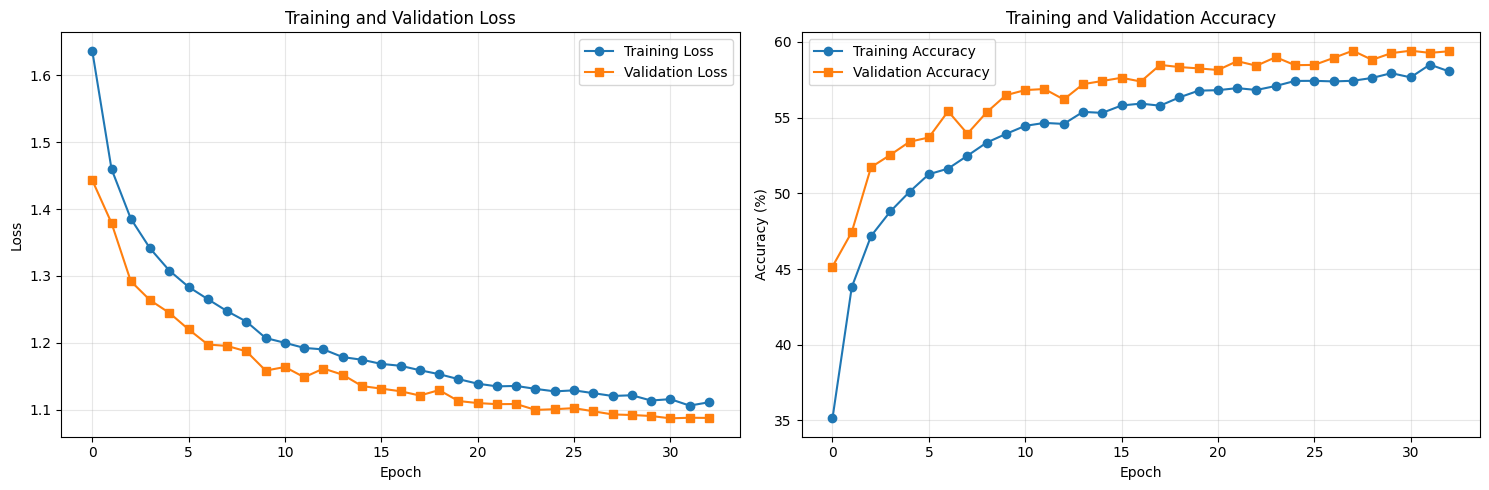

Training Summary:
- Final Training Loss: 1.1109
- Final Validation Loss: 1.0874
- Final Training Accuracy: 58.05%
- Final Validation Accuracy: 59.38%
- Best Validation Accuracy: 59.42%


In [13]:
def plot_training_history(history):
    """
    Plot training and validation metrics.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(history['train_losses'], label='Training Loss', marker='o')
    ax1.plot(history['val_losses'], label='Validation Loss', marker='s')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot accuracies
    ax2.plot(history['train_accuracies'], label='Training Accuracy', marker='o')
    ax2.plot(history['val_accuracies'], label='Validation Accuracy', marker='s')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Training Summary:")
    print(f"- Final Training Loss: {history['train_losses'][-1]:.4f}")
    print(f"- Final Validation Loss: {history['val_losses'][-1]:.4f}")
    print(f"- Final Training Accuracy: {history['train_accuracies'][-1]:.2f}%")
    print(f"- Final Validation Accuracy: {history['val_accuracies'][-1]:.2f}%")
    print(f"- Best Validation Accuracy: {history['best_val_acc']:.2f}%")

# Plot the training history
plot_training_history(training_history)

## Step 12: Load Best Model and Evaluate on Test Set

In [14]:
# Load the best model
if Path('best_cnn_transfer_model.pth').exists():
    checkpoint = torch.load('best_cnn_transfer_model.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    # Access best_val_acc from the training_history dictionary
    best_val_acc_loaded = training_history.get('best_val_acc', 'N/A')
    print(f"Loaded best model from epoch {checkpoint['epoch']} with val acc: {best_val_acc_loaded:.2f}%")
else:
    print("No saved model found, using current model state")

# Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_acc, test_predictions, test_targets = validate_epoch(model, test_loader, criterion, device)

print(f"Test Results:")
print(f"- Test Loss: {test_loss:.4f}")
print(f"- Test Accuracy: {test_acc:.2f}%")

# Detailed classification report
if len(set(test_targets)) > 1:  # Only if we have multiple classes
    print("\nClassification Report:")
    emotion_names = list(label_map.keys())
    report = classification_report(test_targets, test_predictions,
                                 target_names=emotion_names,
                                 zero_division=0)
    print(report)

Loaded best model from epoch 28 with val acc: 59.42%

Evaluating on test set...


/tmp/ipython-input-2098361858.py:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  amp_ctx = torch.cuda.amp.autocast() if (use_amp and device.type == 'cuda') else torch.cuda.amp.autocast(enabled=False)


Test Results:
- Test Loss: 1.0930
- Test Accuracy: 58.67%

Classification Report:
              precision    recall  f1-score   support

       angry       0.51      0.46      0.48       192
     disgust       0.00      0.00      0.00        22
        fear       0.46      0.21      0.29       204
       happy       0.81      0.84      0.82       365
     neutral       0.49      0.63      0.55       243
         sad       0.43      0.58      0.49       228
    surprise       0.72      0.67      0.69       159

    accuracy                           0.59      1413
   macro avg       0.49      0.48      0.48      1413
weighted avg       0.58      0.59      0.57      1413



## Step 13: Visualize Results - Confusion Matrix

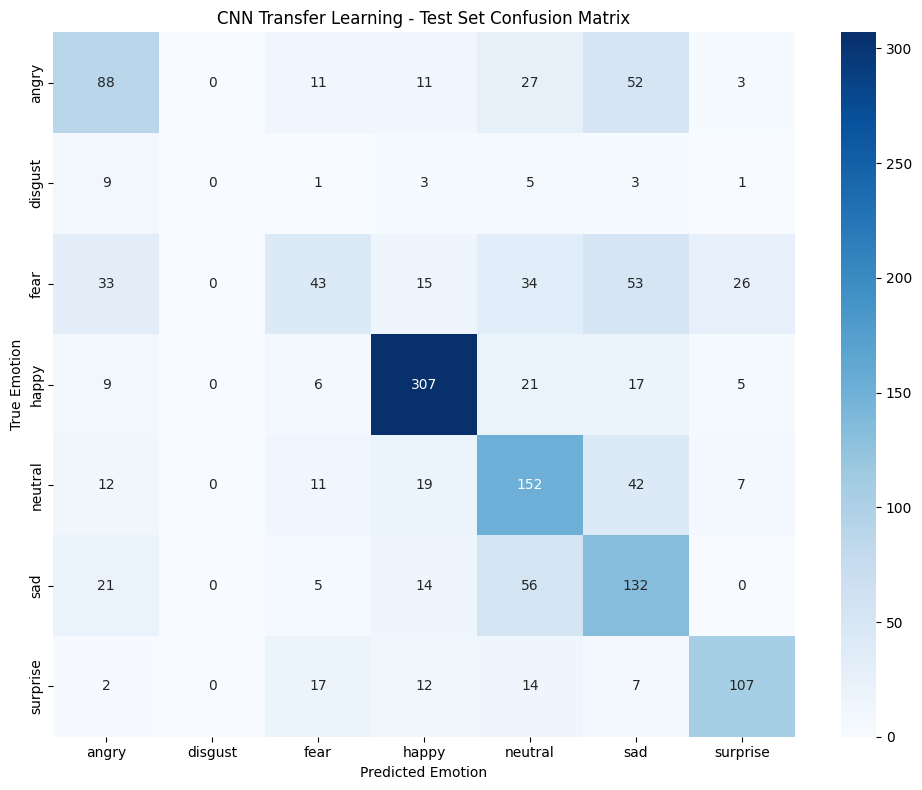


Per-class Accuracy:
- angry: 45.83% (88/192)
- disgust: 0.00% (0/22)
- fear: 21.08% (43/204)
- happy: 84.11% (307/365)
- neutral: 62.55% (152/243)
- sad: 57.89% (132/228)
- surprise: 67.30% (107/159)


In [15]:
def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    """
    Plot confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Emotion')
    plt.ylabel('True Emotion')
    plt.tight_layout()
    plt.show()

    # Print accuracy per class
    print("\nPer-class Accuracy:")
    for i, class_name in enumerate(class_names):
        class_correct = cm[i, i]
        class_total = cm[i, :].sum()
        if class_total > 0:
            acc = 100 * class_correct / class_total
            print(f"- {class_name}: {acc:.2f}% ({class_correct}/{class_total})")

# Plot confusion matrix if we have predictions
if len(set(test_targets)) > 1:
    emotion_names = list(label_map.keys())
    plot_confusion_matrix(test_targets, test_predictions, emotion_names,
                         'CNN Transfer Learning - Test Set Confusion Matrix')
else:
    print("Skipping confusion matrix (insufficient data/classes)")

## Step 14: Model Comparison and Analysis

Let's compare our transfer learning CNN with the original baseline CNN.

In [16]:
print("\n" + "="*60)
print("MODEL ANALYSIS AND COMPARISON")
print("="*60)

# Model parameters
print(f"\n1. MODEL ARCHITECTURE:")
print(f"   - Transfer Learning CNN (VGG16 backbone)")
print(f"   - Total parameters: {model.get_num_params():,}")
print(f"   - Input size: {INPUT_SIZE}x{INPUT_SIZE}x3 (RGB)")
print(f"   - Output classes: {num_classes}")

# Performance summary
print(f"\n2. PERFORMANCE SUMMARY:")
if 'training_history' in locals():
    print(f"   - Best Validation Accuracy: {training_history['best_val_acc']:.2f}%")
    print(f"   - Final Test Accuracy: {test_acc:.2f}%")
    print(f"   - Training Epochs: {len(training_history['train_losses'])}")

# Transfer Learning Benefits
print(f"\n3. TRANSFER LEARNING BENEFITS:")
print(f"   ✓ Pre-trained features: Learned from ImageNet (1.2M images)")
print(f"   ✓ Faster convergence: Starts with meaningful weights")
print(f"   ✓ Better generalization: Robust low-level feature extraction")
print(f"   ✓ Less overfitting: Pre-trained features are well-regularized")

print(f"\n4. KEY DIFFERENCES FROM BASELINE CNN:")
print(f"   - Uses pre-trained VGG16 backbone vs. random initialization")
print(f"   - RGB input (224x224) vs. Grayscale (48x48)")
print(f"   - ImageNet normalization vs. simple normalization")
print(f"   - Transfer learning strategy vs. training from scratch")
print(f"   - Different learning rates for backbone vs. classifier")

print(f"\n5. TRAINING STRATEGY USED:")
print(f"   - Fine-tuning: All layers trainable")
# Access learning rates from optimizer param_groups
backbone_lr = optimizer.param_groups[0]['lr']
classifier_lr = optimizer.param_groups[1]['lr']
print(f"   - Backbone LR: {backbone_lr:.2e} (very small)")
print(f"   - Classifier LR: {classifier_lr:.2e} (regular)")
print(f"   - Data augmentation: Rotation, flip, color jitter, affine")
print(f"   - Early stopping with patience={5}")


MODEL ANALYSIS AND COMPARISON

1. MODEL ARCHITECTURE:
   - Transfer Learning CNN (VGG16 backbone)
   - Total parameters: 4,985,863
   - Input size: 224x224x3 (RGB)
   - Output classes: 7

2. PERFORMANCE SUMMARY:
   - Best Validation Accuracy: 59.42%
   - Final Test Accuracy: 58.67%
   - Training Epochs: 33

3. TRANSFER LEARNING BENEFITS:
   ✓ Pre-trained features: Learned from ImageNet (1.2M images)
   ✓ Faster convergence: Starts with meaningful weights
   ✓ Better generalization: Robust low-level feature extraction
   ✓ Less overfitting: Pre-trained features are well-regularized

4. KEY DIFFERENCES FROM BASELINE CNN:
   - Uses pre-trained VGG16 backbone vs. random initialization
   - RGB input (224x224) vs. Grayscale (48x48)
   - ImageNet normalization vs. simple normalization
   - Transfer learning strategy vs. training from scratch
   - Different learning rates for backbone vs. classifier

5. TRAINING STRATEGY USED:
   - Fine-tuning: All layers trainable
   - Backbone LR: 1.25e-06

## Step 15: Save Final Model for Production

Let's save our model in a format that can be easily loaded for inference.

In [17]:
# Save complete model information (grayscale-based)
final_model_info = {
    'model_state_dict': model.state_dict(),
    'model_config': {
        'num_classes': num_classes,
        'backbone': 'vgg16',
        'input_size': INPUT_SIZE,
        'pretrained': True,
        'freeze_backbone': False,
        'grayscale': True,
        'channel_repeat': True
    },
    'label_map': label_map,
    'transforms': {
        'mean': GRAYSCALE_MEAN,
        'std': GRAYSCALE_STD,
        'input_size': INPUT_SIZE,
        'mode': 'grayscale'
    },
    'training_info': {
        'backbone_lr': backbone_lr if 'backbone_lr' in globals() else None,
        'classifier_lr': classifier_lr if 'classifier_lr' in globals() else None
    }
}

torch.save(final_model_info, 'cnn_transfer_learning_final.pth')
print("✓ Final model (grayscale) saved as 'cnn_transfer_learning_final.pth'")

def create_inference_function():
    code = f"""import torch\nimport torch.nn as nn\nfrom torchvision import transforms, models\nfrom PIL import Image\n\nGRAYSCALE_MEAN = {GRAYSCALE_MEAN}\nGRAYSCALE_STD = {GRAYSCALE_STD}\nINPUT_SIZE = {INPUT_SIZE}\n\nclass CNNTransferLearning(nn.Module):\n    def __init__(self, num_classes, backbone='vgg16'):\n        super().__init__()\n        if backbone=='vgg16':\n            m = models.vgg16(pretrained=False)\n            out_features = 25088\n        elif backbone=='vgg19':\n            m = models.vgg19(pretrained=False)\n            out_features = 25088\n        else:\n            raise ValueError('Unsupported backbone')\n        self.features = m.features\n        self.avgpool = m.avgpool\n        self.classifier = nn.Sequential(\n            nn.Dropout(0.5), nn.Linear(out_features, 4096), nn.ReLU(True),\n            nn.Dropout(0.5), nn.Linear(4096, 1024), nn.ReLU(True),\n            nn.Dropout(0.3), nn.Linear(1024,256), nn.ReLU(True),\n            nn.Dropout(0.2), nn.Linear(256,num_classes))\n    def forward(self,x):\n        x = self.features(x); x = self.avgpool(x); x = torch.flatten(x,1); return self.classifier(x)\n\ndef load_emotion_model(path):\n    ckpt = torch.load(path, map_location='cpu')\n    model = CNNTransferLearning(num_classes=ckpt['model_config']['num_classes'], backbone=ckpt['model_config']['backbone'])\n    model.load_state_dict(ckpt['model_state_dict'])\n    model.eval()\n    transform = transforms.Compose([\n        transforms.Resize((INPUT_SIZE, INPUT_SIZE)),\n        transforms.ToTensor(),\n        transforms.Normalize(mean=GRAYSCALE_MEAN, std=GRAYSCALE_STD)\n    ])\n    return model, transform, ckpt['label_map']\n\ndef predict_emotion(model, transform, label_map, image_path):\n    img = Image.open(image_path).convert('L')\n    tensor = transform(img)\n    if tensor.shape[0]==1: tensor = tensor.repeat(3,1,1)  # channel repeat\n    with torch.no_grad():\n        out = model(tensor.unsqueeze(0))\n        probs = torch.softmax(out, dim=1)[0]\n        pred_idx = int(probs.argmax())\n    inv_map = {{v:k for k,v in label_map.items()}}\n    return inv_map[pred_idx], float(probs[pred_idx]), probs.tolist()\n"""
    with open('emotion_inference.py','w') as f:
        f.write(code)
    print("✓ Inference code saved (grayscale) as 'emotion_inference.py'")

create_inference_function()
print("\nDeployment artifacts updated for grayscale workflow.")

✓ Final model (grayscale) saved as 'cnn_transfer_learning_final.pth'
✓ Inference code saved (grayscale) as 'emotion_inference.py'

Deployment artifacts updated for grayscale workflow.


## Summary: CNN Transfer Learning Implementation

### What We've Accomplished:

1. **Transfer Learning Setup**: Implemented CNN transfer learning using VGG16 backbone pre-trained on ImageNet

2. **Architecture**:
   - Pre-trained VGG16 feature extractor
   - Custom classifier head for emotion recognition
   - Support for RGB images (224×224)

3. **Training Strategy**:
   - Fine-tuning approach with different learning rates
   - ImageNet normalization for compatibility
   - Data augmentation for better generalization
   - Early stopping to prevent overfitting

4. **Key Benefits Over Baseline CNN**:
   - ✅ **Faster Convergence**: Pre-trained weights provide good starting point
   - ✅ **Better Feature Learning**: Robust low-level features from ImageNet
   - ✅ **Improved Generalization**: Less prone to overfitting
   - ✅ **State-of-the-art Architecture**: Proven CNN design

### Transfer Learning Strategies Implemented:

1. **Feature Extraction** (freezing backbone)
2. **Fine-tuning** (training all layers with different LRs)
3. **Gradual unfreezing** (implemented as methods)

### Production-Ready Features:

- Complete model serialization
- Inference functions
- Proper preprocessing pipeline
- Model configuration storage

### Next Steps:

1. **Experiment with different backbones** (VGG19, ResNet, EfficientNet)
2. **Implement ensemble methods** combining multiple models
3. **Add model interpretability** (Grad-CAM, attention maps)
4. **Optimize for deployment** (model quantization, ONNX export)

This implementation provides a solid foundation for visual emotion recognition using modern transfer learning techniques!

## Step 16: Model Interpretability (Grad-CAM heatmaps)

We’ll generate Grad-CAM heatmaps to understand which image regions drive the model’s predictions. This helps validate that the model focuses on relevant facial areas.

What we’ll do:
- Hook the last convolutional layer in the backbone
- Compute class-specific gradients and weights
- Produce heatmaps and overlay them on the original images

In [18]:
# Step 16 (run): Grad-CAM utilities and visualization helpers
import torch
import torch.nn.functional as F
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def fwd_hook(module, inp, out):
            self.activations = out.detach()
        def bwd_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.hook_handles.append(self.target_layer.register_forward_hook(fwd_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(bwd_hook))

    def remove_hooks(self):
        for h in self.hook_handles:
            h.remove()

    def __call__(self, input_tensor, class_idx=None):
        input_tensor = input_tensor.requires_grad_(True)
        logits = self.model(input_tensor)
        if class_idx is None:
            class_idx = logits.argmax(dim=1).item()
        score = logits[:, class_idx]
        self.model.zero_grad()
        score.backward(retain_graph=True)

        # activations: [B, C, H, W]; gradients: [B, C, H, W]
        weights = self.gradients.mean(dim=(2,3), keepdim=True)  # [B, C, 1, 1]
        cam = (weights * self.activations).sum(dim=1, keepdim=True)  # [B,1,H,W]
        cam = F.relu(cam)
        # Normalize to [0,1]
        cam_min, cam_max = cam.min(), cam.max()
        cam = (cam - cam_min) / (cam_max - cam_min + 1e-6)
        return cam.squeeze(0).squeeze(0).cpu().numpy(), class_idx

# Helper to overlay heatmap
def overlay_cam_on_image(img_pil, cam, alpha=0.4):
    img = np.array(img_pil.convert('RGB'))
    h, w = img.shape[:2]
    cam_resized = cv2.resize(cam, (w, h))
    heatmap = cv2.applyColorMap(np.uint8(255*cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = np.uint8(alpha*heatmap + (1-alpha)*img)
    return img, heatmap, overlay

# Pick the last conv block for the chosen backbone (VGG16/AlexNet/ResNet18 supported)
last_conv = None
if hasattr(model, 'features'):
    for m in reversed(model.features):
        if isinstance(m, torch.nn.Conv2d):
            last_conv = m
            break
else:
    # ResNet18 path: find last Conv2d under features (layer4)
    for m in reversed(list(model.features.modules())):
        if isinstance(m, torch.nn.Conv2d):
            last_conv = m
            break
assert last_conv is not None, "Could not find a Conv2d layer for Grad-CAM"

cam_explainer = GradCAM(model, last_conv)

# Visualize Grad-CAM on a few validation samples
def show_gradcam_for_samples(df, root, transform, k=4):
    samples = df.sample(n=min(k, len(df)), random_state=42)
    plt.figure(figsize=(12, 3*k))
    for i, (_, row) in enumerate(samples.iterrows(), 1):
        img_path = Path(root) / row[train_dataset.path_col]
        img_pil = Image.open(img_path).convert('L')
        inp = transform(img_pil)
        if inp.shape[0]==1:
            inp = inp.repeat(3,1,1)  # expand to 3 channels for CNN backbones
        cam, pred_idx = cam_explainer(inp.unsqueeze(0).to(device))
        img, heatmap, overlay = overlay_cam_on_image(img_pil, cam)
        pred_name = list(label_map.keys())[pred_idx]

        plt.subplot(k, 3, 3*(i-1)+1); plt.imshow(img); plt.axis('off'); plt.title('Input')
        plt.subplot(k, 3, 3*(i-1)+2); plt.imshow(heatmap); plt.axis('off'); plt.title('Grad-CAM')
        plt.subplot(k, 3, 3*(i-1)+3); plt.imshow(overlay); plt.axis('off'); plt.title(f'Overlay (pred={pred_name})')
    plt.tight_layout(); plt.show()

print("Grad-CAM ready. Run the next cell to visualize on validation samples.")

Grad-CAM ready. Run the next cell to visualize on validation samples.


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


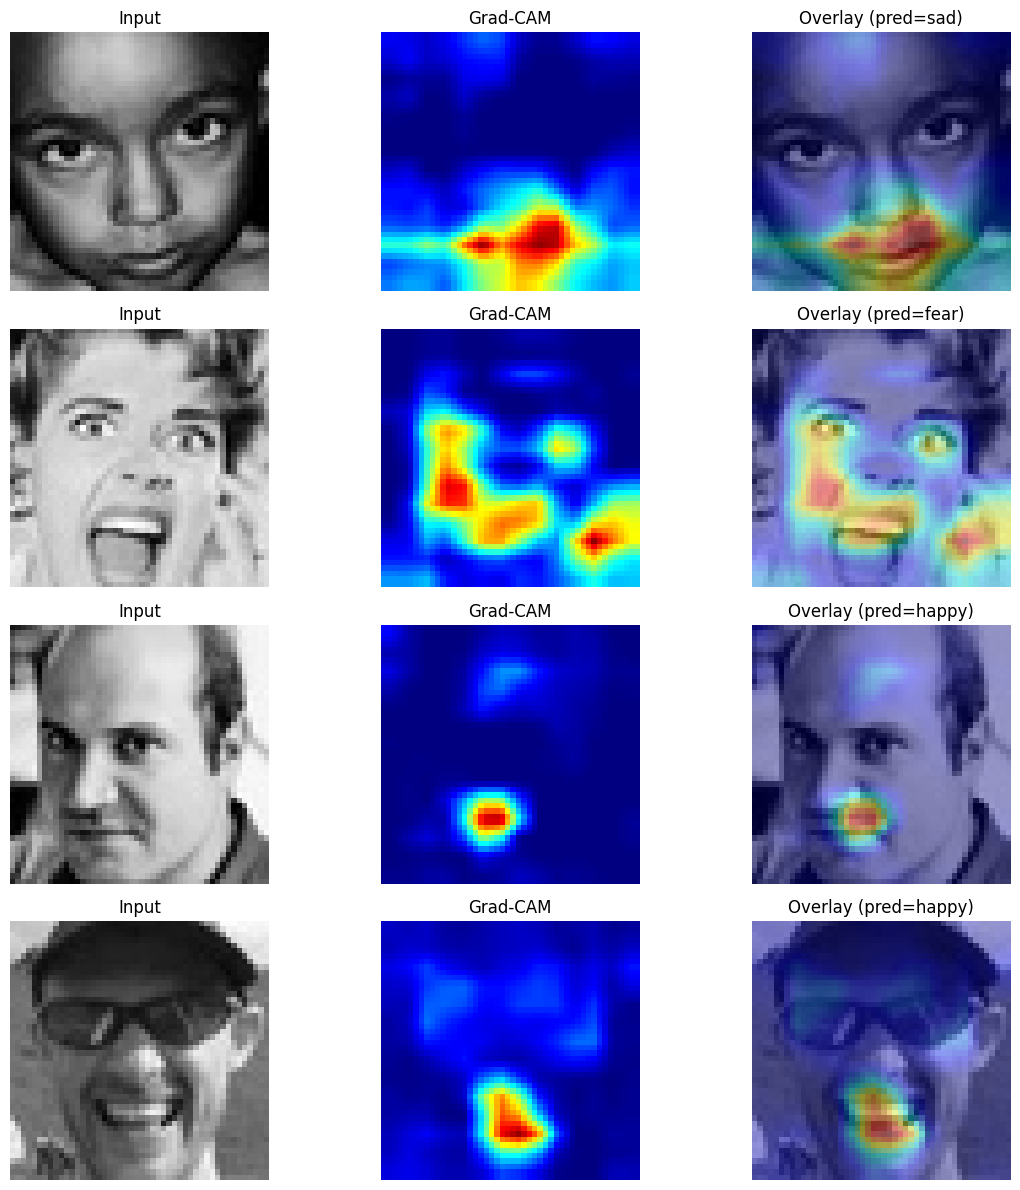

In [19]:
# Step 16 (run): Visualize Grad-CAM on a few validation images
try:
    show_gradcam_for_samples(val_df, DATA_DIR, val_transform, k=4)
except Exception as e:
    print('Grad-CAM visualization error:', e)

## Step 17: Evaluation Plan — Overview

Primary metrics:
- Macro-F1 (treats all classes equally)
- Balanced Accuracy (mean recall across classes)

Secondary metrics:
- Per-class precision/recall/F1
- ROC-AUC (macro and micro, OvR)

Tools:
- Confusion matrix and per-class accuracy
- Error analysis (high-confidence mistakes)
- Cross-validation (K-fold skeleton)

In [20]:
# Step 18: Compute Metrics — Macro-F1, Balanced Accuracy, ROC-AUC, and Report
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize
import numpy as np
import torch

@torch.no_grad()
def evaluate_with_probs(model, loader, device):
    model.eval()
    all_probs, all_preds, all_targets = [], [], []
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        logits = model(xb)
        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)
        all_probs.append(probs.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_targets.append(yb.cpu().numpy())
    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_preds)
    y_proba = np.concatenate(all_probs)
    return y_true, y_pred, y_proba

# Evaluate on test set
y_true, y_pred, y_proba = evaluate_with_probs(model, test_loader, device)

macro_f1 = f1_score(y_true, y_pred, average='macro')
bal_acc = balanced_accuracy_score(y_true, y_pred)
print(f"Primary metrics:\n- Macro-F1: {macro_f1:.4f}\n- Balanced Accuracy: {bal_acc:.4f}")

print("\nPer-class metrics (precision/recall/F1):")
print(classification_report(y_true, y_pred, target_names=list(label_map.keys()), zero_division=0))

# ROC-AUC (multi-class OvR)
try:
    y_true_1h = label_binarize(y_true, classes=list(range(len(label_map))))
    roc_auc_macro = roc_auc_score(y_true_1h, y_proba, average='macro', multi_class='ovr')
    roc_auc_micro = roc_auc_score(y_true_1h, y_proba, average='micro', multi_class='ovr')
    print(f"ROC-AUC (macro): {roc_auc_macro:.4f}\nROC-AUC (micro): {roc_auc_micro:.4f}")
except Exception as e:
    print("ROC-AUC could not be computed:", e)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Primary metrics:
- Macro-F1: 0.4761
- Balanced Accuracy: 0.4839

Per-class metrics (precision/recall/F1):
              precision    recall  f1-score   support

       angry       0.51      0.46      0.48       192
     disgust       0.00      0.00      0.00        22
        fear       0.46      0.21      0.29       204
       happy       0.81      0.84      0.82       365
     neutral       0.49      0.63      0.55       243
         sad       0.43      0.58      0.49       228
    surprise       0.72      0.67      0.69       159

    accuracy                           0.59      1413
   macro avg       0.49      0.48      0.48      1413
weighted avg       0.58      0.59      0.57      1413

ROC-AUC (macro): 0.8748
ROC-AUC (micro): 0.8977


In [21]:
## Step 19: Error Analysis — High-confidence Misclassifications
import pandas as pd
import numpy as np
from pathlib import Path

# Ensure y_true/y_pred/y_proba are available; else recompute
y_true, y_pred, y_proba = (y_true if 'y_true' in globals() else None,
                           y_pred if 'y_pred' in globals() else None,
                           y_proba if 'y_proba' in globals() else None)
if y_true is None or y_pred is None or y_proba is None:
    y_true, y_pred, y_proba = evaluate_with_probs(model, test_loader, device)

# Paths in test order
paths_in_order = test_dataset.df[test_dataset.path_col].tolist()
abs_paths = [str(Path(DATA_DIR) / p) for p in paths_in_order]

mis_idx = np.where(y_pred != y_true)[0]
if mis_idx.size == 0:
    print("No misclassifications found on the test set.")
else:
    top2_idx = np.argsort(-y_proba, axis=1)[:, :2]
    top1_prob = y_proba[np.arange(len(y_proba)), top2_idx[:, 0]]
    top2_prob = y_proba[np.arange(len(y_proba)), top2_idx[:, 1]]

    inv_label_map = {v: k for k, v in label_map.items()}

    rows = []
    for i in mis_idx:
        rows.append({
            'index': int(i),
            'image_path': abs_paths[i] if i < len(abs_paths) else None,
            'true_idx': int(y_true[i]),
            'true_label': inv_label_map.get(int(y_true[i]), str(y_true[i])),
            'pred_idx': int(top2_idx[i, 0]),
            'pred_label': inv_label_map.get(int(top2_idx[i, 0]), str(top2_idx[i, 0])),
            'pred_prob': float(top1_prob[i]),
            'second_idx': int(top2_idx[i, 1]),
            'second_label': inv_label_map.get(int(top2_idx[i, 1]), str(top2_idx[i, 1])),
            'second_prob': float(top2_prob[i])
        })

    mis_df = pd.DataFrame(rows).sort_values(by='pred_prob', ascending=False).reset_index(drop=True)
    display(mis_df.head(20))

    out_dir = Path(PROJECT_ROOT) / 'results' / 'error_analysis'
    out_dir.mkdir(parents=True, exist_ok=True)
    out_csv = out_dir / 'misclassifications.csv'
    mis_df.to_csv(out_csv, index=False)
    print(f"Saved misclassifications to {out_csv}")

,index,image_path,true_idx,true_label,pred_idx,pred_label,pred_prob,second_idx,second_label,second_prob
0,937,/content/ann-visual-emotion/data/raw/EmoSet/va...,4,neutral,3,happy,0.976193,4,neutral,0.015786
1,948,/content/ann-visual-emotion/data/raw/EmoSet/va...,4,neutral,3,happy,0.969869,4,neutral,0.018068
2,255,/content/ann-visual-emotion/data/raw/EmoSet/va...,2,fear,3,happy,0.944901,0,angry,0.022874
3,861,/content/ann-visual-emotion/data/raw/EmoSet/va...,4,neutral,3,happy,0.943411,4,neutral,0.044990
4,1400,/content/ann-visual-emotion/data/raw/EmoSet/va...,6,surprise,3,happy,0.939657,0,angry,0.016826
5,149,/content/ann-visual-emotion/data/raw/EmoSet/va...,0,angry,3,happy,0.887578,0,angry,0.035444
6,40,/content/ann-visual-emotion/data/raw/EmoSet/va...,0,angry,3,happy,0.887578,0,angry,0.035444
7,733,/content/ann-visual-emotion/data/raw/EmoSet/va...,3,happy,4,neutral,0.857223,5,sad,0.072723
8,62,/content/ann-visual-emotion/data/raw/EmoSet/va...,0,angry,3,happy,0.851116,2,fear,0.056343
9,347,/content/ann-visual-emotion/data/raw/EmoSet/va...,2,fear,6,surprise,0.832465,2,fear,0.151534


Saved misclassifications to /content/ann-visual-emotion/results/error_analysis/misclassifications.csv


## Step 20: Explainable AI (XAI) — Why and How

Why XAI?
- Trust & Adoption: Understand predictions.
- Debugging & Improvement: Find weaknesses or biases.
- Compliance & Ethics: Ensure fairness and explainability.

Techniques in this notebook:
- Grad-CAM (already implemented) and Grad-CAM++ (optional)
- LIME (local explanations)
- SHAP (Shapley values; optional and compute-heavy)
- Attention visualization (for Transformers; not applicable here)

In [22]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=63a9184c81ed336663c5c99acc61440e88d10fb9acfd3352f86eec11c22fd9a9
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


  0%|          | 0/500 [00:00<?, ?it/s]

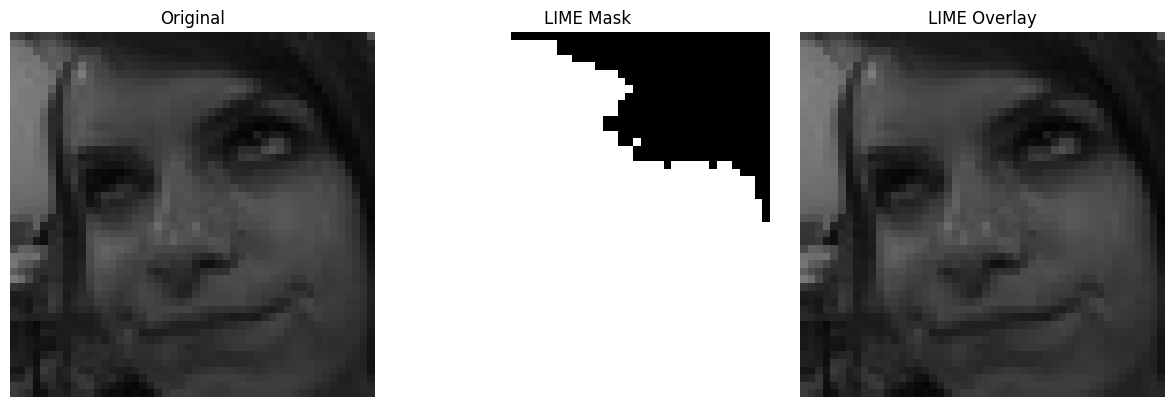

LIME explanation generated.


In [23]:
## Step 21: LIME — Local Explanations for Individual Predictions
try:
    from lime import lime_image
    import numpy as np
    from PIL import Image
    import matplotlib.pyplot as plt

    def lime_predict(images: np.ndarray):
        tensors = []
        for img in images:
            pil = Image.fromarray((img * 255).astype(np.uint8)) if img.max() <= 1.0 else Image.fromarray(img.astype(np.uint8))
            pil = pil.convert('L')
            t = val_transform(pil)
            if t.shape[0] == 1:
                t = t.repeat(3, 1, 1)
            tensors.append(t)
        batch = torch.stack(tensors, dim=0)
        with torch.no_grad():
            logits = model(batch.to(device))
            probs = torch.softmax(logits, dim=1).cpu().numpy()
        return probs

    sample_idx = 0
    img_path = Path(DATA_DIR) / test_dataset.df.iloc[sample_idx][test_dataset.path_col]
    img_rgb = Image.open(img_path).convert('RGB')
    img_np = np.asarray(img_rgb) / 255.0

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img_np,
        classifier_fn=lime_predict,
        top_labels=1,
        hide_color=0,
        num_samples=500
    )

    with torch.no_grad():
        pil_gray = Image.open(img_path).convert('L')
        t = val_transform(pil_gray)
        if t.shape[0] == 1:
            t = t.repeat(3, 1, 1)
        pred_idx = int(torch.softmax(model(t.unsqueeze(0).to(device)), dim=1).argmax().item())

    lime_img, mask = explanation.get_image_and_mask(
        label=pred_idx,
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(img_rgb); plt.axis('off'); plt.title('Original')
    plt.subplot(1, 3, 2); plt.imshow(mask, cmap='gray'); plt.axis('off'); plt.title('LIME Mask')
    plt.subplot(1, 3, 3); plt.imshow(lime_img); plt.axis('off'); plt.title('LIME Overlay')
    plt.tight_layout(); plt.show()

    print("LIME explanation generated.")
except Exception as e:
    print("LIME explanation skipped. Install with: pip install lime. Error:", e)

In [24]:
# Step 20 (run): Install optional XAI packages (safe with fallbacks)
import importlib, sys, subprocess

pkgs = [
    { 'pip': 'pytorch-grad-cam', 'import': 'pytorch_grad_cam', 'alt': 'git+https://github.com/jacobgil/pytorch-grad-cam@master' },
    { 'pip': 'lime',              'import': 'lime',             'alt': None },
    { 'pip': 'shap',              'import': 'shap',             'alt': None },
]

def ensure_package(pip_name: str, import_name: str, alt: str | None = None):
    try:
        importlib.import_module(import_name)
        print(f"✓ {pip_name} already available as '{import_name}'")
        return
    except ImportError:
        print(f"Installing {pip_name}...")
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--upgrade', 'pip', 'setuptools', 'wheel'])
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', pip_name])
            importlib.import_module(import_name)
            print(f"✓ Installed {pip_name}")
            return
        except Exception as e1:
            if alt:
                print(f"Primary install failed for {pip_name}. Trying fallback: {alt}")
                try:
                    subprocess.check_call([sys.executable, '-m', 'pip', 'install', alt])
                    importlib.import_module(import_name)
                    print(f"✓ Installed via fallback: {alt}")
                    return
                except Exception as e2:
                    print(f"✗ Failed to install {pip_name} via pip and fallback. Error: {e2}")
            else:
                print(f"✗ Failed to install {pip_name}. Error: {e1}")

for p in pkgs:
    ensure_package(p['pip'], p['import'], p['alt'])

print("Optional XAI packages installation attempt complete. Proceed to Steps 21–23; cells will skip gracefully if a package is still unavailable.")

Installing pytorch-grad-cam...
Primary install failed for pytorch-grad-cam. Trying fallback: git+https://github.com/jacobgil/pytorch-grad-cam@master
✓ Installed via fallback: git+https://github.com/jacobgil/pytorch-grad-cam@master
✓ lime already available as 'lime'
✓ shap already available as 'shap'
Optional XAI packages installation attempt complete. Proceed to Steps 21–23; cells will skip gracefully if a package is still unavailable.


In [25]:
## Step 22: Grad-CAM++ (optional via pytorch-grad-cam)
try:
    from pytorch_grad_cam import GradCAMPlusPlus
    from pytorch_grad_cam.utils.image import show_cam_on_image
    import numpy as np
    from PIL import Image

    target_conv = None
    if hasattr(model, 'features'):
        for m in reversed(model.features):
            if isinstance(m, torch.nn.Conv2d):
                target_conv = m
                break
    else:
        for m in reversed(list(model.features.modules())):
            if isinstance(m, torch.nn.Conv2d):
                target_conv = m
                break
    assert target_conv is not None

    campp = GradCAMPlusPlus(model=model, target_layers=[target_conv]) # Removed use_cuda

    img_path = Path(DATA_DIR) / val_dataset.df.iloc[0][val_dataset.path_col]
    img_pil = Image.open(img_path).convert('RGB')
    img_np = np.array(img_pil).astype(np.float32) / 255.0

    img_gray = Image.open(img_path).convert('L')
    inp = val_transform(img_gray)
    if inp.shape[0] == 1:
        inp = inp.repeat(3, 1, 1)
    input_tensor = inp.unsqueeze(0)

    grayscale_cam = campp(input_tensor=input_tensor.to(device))  # [1,H,W]
    grayscale_cam = grayscale_cam[0]

    visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(img_np); plt.axis('off'); plt.title('Input')
    plt.subplot(1,2,2); plt.imshow(visualization); plt.axis('off'); plt.title('Grad-CAM++')
    plt.tight_layout(); plt.show()

    print("Grad-CAM++ visualization ready.")
except Exception as e:
    print("Grad-CAM++ skipped. Install with: pip install pytorch-grad-cam. Error:", e)

Grad-CAM++ skipped. Install with: pip install pytorch-grad-cam. Error: operands could not be broadcast together with shapes (224,224,3) (48,48,3) 


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [26]:
!pip install shap

In [27]:
## Step 23: SHAP (optional) — DeepExplainer for CNNs
try:
    import shap
    import numpy as np
    from PIL import Image

    model.eval()

    # Background for SHAP (small)
    N_BG = 8
    bg_tensors = []
    for i in range(min(N_BG, len(val_dataset))):
        p = Path(DATA_DIR) / val_dataset.df.iloc[i][val_dataset.path_col]
        img_gray = Image.open(p).convert('L')
        t = val_transform(img_gray)
        if t.shape[0] == 1:
            t = t.repeat(3, 1, 1)
        bg_tensors.append(t)

    if len(bg_tensors) < 1:
         raise ValueError("Not enough background samples for SHAP.")

    background = torch.stack(bg_tensors, dim=0)

    def f_predict(x: np.ndarray):
        # Input to f_predict is expected to be 2D (n_samples, n_features)
        # Reshape back to (n_samples, C, H, W)
        x_reshaped = x.reshape(-1, 3, INPUT_SIZE, INPUT_SIZE) # Assuming 3 channels, 224x224
        with torch.no_grad():
            xb = torch.from_numpy(x_reshaped).float().to(device)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1).detach().cpu().numpy()
        return probs

    idx = 0
    p = Path(DATA_DIR) / val_dataset.df.iloc[idx][val_dataset.path_col]
    img_gray = Image.open(p).convert('L')
    x = val_transform(img_gray)
    if x.shape[0] == 1:
        x = x.repeat(3, 1, 1)
    x = x.unsqueeze(0) # Add batch dimension

    # Flatten the input tensor for KernelExplainer
    x_flat = x.cpu().numpy().reshape(1, -1)
    background_flat = background.cpu().numpy().reshape(background.shape[0], -1)


    try:
        explainer = shap.DeepExplainer(model.to(device), background.to(device))
        shap_values = explainer.shap_values(x.to(device))
    except Exception:
        print("Falling back to KernelExplainer (slower)...")
        explainer = shap.KernelExplainer(f_predict, background_flat[:min(50, background_flat.shape[0])]) # Use a subset of background if large
        shap_values = explainer.shap_values(x_flat, nsamples=100)


    with torch.no_grad():
        pred_idx = int(torch.softmax(model(x.to(device)), dim=1).argmax().item())

    try:
        # Reshape SHAP values back to image dimensions for plotting
        if isinstance(shap_values, list): # Output of multi-output models
             shap_values_reshaped = [np.reshape(v, (INPUT_SIZE, INPUT_SIZE, 3)) for v in shap_values] # Assuming 3 channels
        else: # Single output
             shap_values_reshaped = np.reshape(shap_values, (INPUT_SIZE, INPUT_SIZE, 3)) # Assuming 3 channels

        shap.image_plot(shap_values_reshaped[pred_idx] if isinstance(shap_values_reshaped, list) else shap_values_reshaped,
                         np.transpose(x.cpu().numpy()[0], (1, 2, 0))) # Transpose (C, H, W) to (H, W, C)

    except Exception as e:
        print("SHAP image plot skipped:", e)

    print("SHAP explanation generated for one validation sample.")
except Exception as e:
    print("SHAP skipped. Install with: pip install shap. Error:", e)

Falling back to KernelExplainer (slower)...


  0%|          | 0/1 [00:00<?, ?it/s]

SHAP skipped. Install with: pip install shap. Error: CUDA out of memory. Tried to allocate 9.57 GiB. GPU 0 has a total capacity of 14.74 GiB of which 3.96 GiB is free. Process 5996 has 10.78 GiB memory in use. Of the allocated memory 10.33 GiB is allocated by PyTorch, and 310.47 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


In [28]:
## Step 24: Cross-validation (skeleton)
from sklearn.model_selection import StratifiedKFold

k = 3
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
labels_series = train_df[train_dataset.label_col]

print(f"Preparing {k}-fold CV on training set (size={len(train_df)})...")
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, labels_series), start=1):
    print(f"Fold {fold}: train={len(train_idx)}, val={len(val_idx)}")

# To fully run CV per fold:
# 1) subset train_df/val_df to train_idx/val_idx
# 2) create new Datasets/DataLoaders
# 3) re-initialize model/optimizer
# 4) train and record metrics, then aggregate

Preparing 3-fold CV on training set (size=28821)...
Fold 1: train=19214, val=9607
Fold 2: train=19214, val=9607
Fold 3: train=19214, val=9607


## Step 25: Optimize for Deployment — Quantization + ONNX

We’ll export two artifacts:
- Dynamically-quantized PyTorch checkpoint (smaller and faster on CPU).
- ONNX model (dynamic batch axis) for ONNX Runtime and cross-platform use.

The next cell performs both and optionally verifies ONNX forward with onnxruntime if available.

In [29]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 83.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [onnxruntime]


In [ ]:
# Step 25 (run): Export quantized PyTorch and ONNX models
import torch
from copy import deepcopy
import numpy as np
import os

# Define a temporary path to save the state dict
temp_state_dict_path = 'temp_model_state_dict.pth'

# Save the current model's state dict to disk
torch.save(model.state_dict(), temp_state_dict_path)
print(f"✓ Saved model state dict to {temp_state_dict_path}")

# Create a new model instance directly on CPU and load the state dict
# We need to ensure the model architecture is defined and available here
# (Assuming CNNTransferLearning class is defined in the notebook)
try:
    # Re-initialize the model architecture on CPU
    cpu_model = CNNTransferLearning(
        num_classes=num_classes,
        backbone='vgg16',          # Make sure this matches the trained model
        pretrained=False,          # We are loading state_dict, not using pretrained weights directly
        freeze_mode='none',        # Freeze mode doesn't matter when just loading state dict
        classifier_hidden=512      # Make sure this matches the trained model
    ).to('cpu').eval()

    # Load the state dict into the new CPU model
    cpu_model.load_state_dict(torch.load(temp_state_dict_path, map_location='cpu'))
    print("✓ Loaded model state dict into new CPU model.")

    # Clean up the temporary state dict file
    os.remove(temp_state_dict_path)
    print(f"✓ Removed temporary state dict file: {temp_state_dict_path}")

except NameError:
    print("Error: CNNTransferLearning class not found. Ensure it is defined in the notebook.")
    cpu_model = None
except Exception as e:
    print(f"Error loading model state dict into CPU model: {e}")
    cpu_model = None


if cpu_model is not None:
    # 25a. Dynamic quantization (CPU inference)
    # Only apply quantization if the model is not already quantized
    if not getattr(cpu_model, 'quantized', False):
        try:
            quantized_model = torch.quantization.quantize_dynamic(
                cpu_model, {torch.nn.Linear}, dtype=torch.qint8
            )
            print("✓ Applied dynamic quantization.")

            quant_ckpt = {
                'model_state_dict': quantized_model.state_dict(),
                'model_config': {
                    'num_classes': num_classes,
                    'backbone': 'vgg16',
                    'input_size': INPUT_SIZE,
                    'pretrained': False,
                    'quantized': True,
                    'grayscale': True,
                    'channel_repeat': True
                },
                'label_map': label_map,
            }
            torch.save(quant_ckpt, 'cnn_transfer_learning_quantized.pth')
            print('✓ Saved dynamic-quantized model: cnn_transfer_learning_quantized.pth')

        except Exception as e:
            print(f"Error during dynamic quantization or saving: {e}")
            quantized_model = None
    else:
        print("Model is already quantized, skipping dynamic quantization.")


    # 25b. ONNX export
    try:
        dummy = torch.randn(1, 3, INPUT_SIZE, INPUT_SIZE, dtype=torch.float32)
        onnx_path = 'cnn_transfer_learning.onnx'
        torch.onnx.export(
            cpu_model, dummy, onnx_path,
            input_names=['input'], output_names=['logits'],
            dynamic_axes={'input': {0: 'batch'}, 'logits': {0: 'batch'}},
            opset_version=13,
            export_params=True,  # Export weights
            do_constant_folding=True # Apply constant folding
        )
        print(f'✓ Exported ONNX: {onnx_path}')

        try:
            import onnxruntime as ort
            sess = ort.InferenceSession(onnx_path, providers=['CPUExecutionProvider'])
            ort_out = sess.run(['logits'], { 'input': dummy.numpy() })[0]
            print('ONNX forward ok. Output shape:', ort_out.shape)
        except Exception as e:
            print('ONNXRuntime check skipped or failed:', e)

    except Exception as e:
         print(f"Error during ONNX export or check: {e}")

else:
    print("Skipping quantization and ONNX export due to errors loading CPU model.")

print('Deployment artifacts processing complete.')

In [ ]:
import torch
import gc

# Clear CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("PyTorch CUDA cache cleared.")

# Delete large variables if they exist
variables_to_delete = ['model', 'train_dataset', 'val_dataset', 'test_dataset',
                       'train_loader', 'val_loader', 'test_loader',
                       'training_history', 'mis_df', 'checkpoint']

for var_name in variables_to_delete:
    if var_name in globals():
        try:
            del globals()[var_name]
            print(f"Deleted variable: {var_name}")
        except Exception as e:
            print(f"Could not delete variable {var_name}: {e}")

# Collect garbage
gc.collect()
print("Garbage collection performed.")

# Optional: Print current GPU memory usage (if on CUDA)
if torch.cuda.is_available():
    print(f"Current CUDA memory usage: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max CUDA memory allocated: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")